In [1]:
!git clone https://github.com/AleksL04/ML-Project.git
%cd ML-Project

Cloning into 'ML-Project'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 166 (delta 78), reused 142 (delta 54), pack-reused 0 (from 0)
Receiving objects: 100% (166/166), 81.16 KiB | 6.24 MiB/s, done.
Resolving deltas: 100% (78/78), done.
/content/ML-Project


In [2]:
!git pull
import sys
modules_to_clear = [
    'model_code.LSTM_code',
    'model_code.CNN_code',
    'model_code.Blender_code',
    'model_code.Bayes_code',
    'process_df' 
]

for module in modules_to_clear:
    if module in sys.modules:
        del sys.modules[module]
        print(f"Removed {module} from cache.")

Already up to date.


In [3]:
%%capture
!pip install --upgrade gensim
!gdown --folder 1rl_TJMHtcP-S0fTHNUpr9oi8Ndz2Y5z4 -O project_data
!gdown --folder 1RmC_We2lfsJontwrxlc4dzqEY_mNy-UW -O word2vec_model

!pip install --upgrade scikeras
!pip install "scikit-learn<1.6"


In [4]:
ls -l

total 84
-rw-r--r-- 1 root root 65918 Dec 12 22:50 main_console.ipynb
drwxr-xr-x 2 root root  4096 Dec 12 22:50 model_code/
-rw-r--r-- 1 root root  1536 Dec 12 22:50 process_df.py
drwxr-xr-x 2 root root  4096 Dec 12 22:50 project_data/
drwxr-xr-x 2 root root  4096 Dec 12 22:50 word2vec_model/


In [5]:
import pandas as pd
import numpy as np

In [6]:
train_df = pd.read_csv('project_data/train.csv')
valid_df = pd.read_csv('project_data/valid.csv')
test_df = pd.read_csv('project_data/test.csv')

Max Token Length: 168
Mean Token Length: 11.25
Median Token Length: 11.0
95th Percentile: 18.0
99th Percentile: 21.0


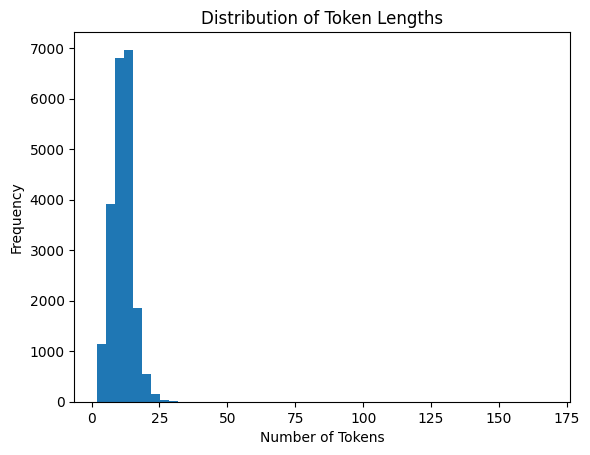

In [7]:
import spacy
import matplotlib.pyplot as plt
from process_df import tokenize_df

# 1. Load the same tokenizer you use in your pipeline
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner", "lemmatizer"])

# 2. Tokenize a copy of the training data so we don't mess up the original
# (This re-uses your existing logic from process_df.py)
analysis_df = tokenize_df(train_df.copy(), nlp)

# 3. Calculate the length of the 'text_split' lists
analysis_df['token_count'] = analysis_df['text_split'].apply(len)

# 4. Print key statistics
print(f"Max Token Length: {analysis_df['token_count'].max()}")
print(f"Mean Token Length: {analysis_df['token_count'].mean():.2f}")
print(f"Median Token Length: {analysis_df['token_count'].median()}")
print(f"95th Percentile: {analysis_df['token_count'].quantile(0.95)}")
print(f"99th Percentile: {analysis_df['token_count'].quantile(0.99)}")

# 5. (Optional) Visualize the distribution
plt.hist(analysis_df['token_count'], bins=50)
plt.title("Distribution of Token Lengths")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

In [8]:
from process_df import process_df

X_train = process_df(train_df)
y_train = train_df['label'].values

X_valid = process_df(valid_df)
y_valid = valid_df['label'].values

X_test = process_df(test_df)
y_test = test_df['label'].values

/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [9]:
from model_code.LSTM_code import trainLSTM, train_CV_LSTM
from model_code.CNN_code import trainCNN, train_CV_CNN
from model_code.Blender_code import trainBlender
from model_code.Bayes_code import trainBayes, predictBayes

In [10]:
# train_CV_LSTM(X_train, y_train, X_valid, y_valid)
#train_CV_CNN(X_train, y_train, X_valid, y_valid)

In [11]:
LSTM_model = trainLSTM(X_train, y_train, X_valid, y_valid)

test_loss, test_acc = LSTM_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8961 - loss: 0.2476
Test Accuracy: 0.8861


In [12]:
CNN_model = trainCNN(X_train, y_train, X_valid, y_valid)

test_loss, test_acc = CNN_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8440 - loss: 0.3137
Test Accuracy: 0.8623


In [13]:
Bayes_model, vectorizer = trainBayes(train_df, valid_df)

Validation Accuracy: 0.7527932960893855
Validation Loss: 0.5019577052166138


In [14]:
val_pred_LSTM = LSTM_model.predict(X_valid).flatten()
val_pred_CNN = CNN_model.predict(X_valid).flatten()
_,_,val_pred_Bayes = predictBayes(Bayes_model, valid_df, vectorizer)

X_meta_train = np.column_stack([
    val_pred_LSTM,
    val_pred_CNN,
    val_pred_Bayes
])

y_meta_train = y_valid

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [15]:
# val_pred_LSTM = LSTM_model.predict(X_valid)
# val_pred_CNN = CNN_model.predict(X_valid)
# val_pred_Bayes = predictBayes(Bayes_model, valid_df, vectorizer)
# print(val_pred_Bayes)
# print(val_pred_LSTM)
# X_meta_train = np.column_stack((val_pred_LSTM, val_pred_CNN))

# y_meta_train = y_valid

In [17]:
Blender_model = trainBlender(X_meta_train, y_meta_train)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5095 - loss: 0.8587 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5197 - loss: 0.8102 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4868 - loss: 0.7987 - learning_rate: 0.0010
Epoch 4/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3750 - loss: 0.8011

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4579 - loss: 0.7704 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4860 - loss: 0.7321 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5089 - loss: 0.7027 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4994 - loss: 0.6792 - learning_rate: 0.0010
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5060 - loss: 0.6525 - learning_rate: 0.0010
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6533 - loss: 0.6324 - learning_rate: 0.0010
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8133 - loss: 0.6197 - learning_rate: 0.0010
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8267 - loss: 0.6066 - learning_rate: 0.0010
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8496 - loss: 0.5914 - learning_rate: 0.0010
Epoch 13/100
23/23 ━━━━━━━━━

In [ ]:
from model_code.XGBoost_code import trainXGB, predictXGB

print("--- Training Entity-Aware XGBoost ---")
XGB_model = trainXGB(train_df, valid_df)

# 2. Get Probabilities for Blender
_, xgb_val_probs = predictXGB(XGB_model, valid_df)
_, xgb_test_probs = predictXGB(XGB_model, test_df)

In [18]:
test_pred_LSTM = LSTM_model.predict(X_test).flatten()
test_pred_CNN = CNN_model.predict(X_test).flatten()
_,_,test_pred_Bayes = predictBayes(Bayes_model, test_df, vectorizer)

X_meta_test = np.column_stack([
    test_pred_LSTM,
    test_pred_CNN,
    test_pred_Bayes
])


# test_pred_LSTM = LSTM_model.predict(X_test)
# test_pred_CNN = CNN_model.predict(X_test)

# X_meta_test = np.column_stack((test_pred_LSTM, test_pred_CNN))

test_loss, test_acc = Blender_model.evaluate(X_meta_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8988 - loss: 0.2532
Test Accuracy: 0.8965


In [29]:
from sklearn.metrics import accuracy_score, log_loss
from xgboost import XGBClassifier

blender = XGBClassifier(n_estimators=15, max_depth=1, learning_rate=0.4)
blender.fit(X_meta_train, y_valid)

test_predictions = blender.predict(X_meta_test)

test_probs = blender.predict_proba(X_meta_test)

acc = accuracy_score(y_test, test_predictions)
loss = log_loss(y_test, test_probs)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Loss: {loss:.4f}")

Test Accuracy: 0.9006
Test Loss: 0.2570


In [33]:
import pandas as pd

def show_blender_errors(model, X_meta, y_true, df_source, set_name="Set"):
    """
    Identifies and prints rows where the Blender model predicted incorrectly.
    """
    # 1. Get Predictions
    # If using Sklearn/XGBoost, .predict() usually returns classes (0 or 1)
    # If using Keras, it returns probabilities, so we round them.
    preds = model.predict(X_meta)
    
    # Handle Keras probability outputs if necessary
    if hasattr(preds, "shape") and len(preds.shape) > 1 and preds.shape[1] == 1:
        preds = (preds > 0.5).astype(int).flatten()
    
    # 2. Create a Mask for Errors
    # Compare prediction vs truth
    error_mask = (preds != y_true)
    
    # 3. Filter the original DataFrame
    error_cases = df_source[error_mask].copy()
    error_cases['predicted'] = preds[error_mask]
    error_cases['actual'] = y_true[error_mask]
    
    # 4. Print Summary and Examples
    print(f"\n=== Errors on {set_name} ===")
    print(f"Total Errors: {len(error_cases)} out of {len(df_source)}")
    print(f"Accuracy: {1 - (len(error_cases)/len(df_source)):.4f}")
    
    if len(error_cases) > 0:
        print("\n--- Example Failures ---")
        # Adjust 'text' to whatever your column name is (e.g., 'text' or 'clean_text')
        pd.set_option('display.max_colwidth', 150) # Show full text
        display(error_cases[['text', 'predicted', 'actual']].head(10))
    
    return error_cases

# --- EXECUTION ---

# 1. Check Errors on Blender's Training Data (Validation Set)
# Uses X_meta_train (which aligns with valid_df)
train_errors = show_blender_errors(
    blender, 
    X_meta_train, 
    y_valid, 
    valid_df, 
    set_name="Validation Set (Blender Train)"
)

# 2. Check Errors on Blender's Testing Data (Test Set)
# Uses X_meta_test (which aligns with test_df)
test_errors = show_blender_errors(
    blender, 
    X_meta_test, 
    y_test, 
    test_df, 
    set_name="Test Set (Blender Test)"
)


=== Errors on Validation Set (Blender Train) ===
Total Errors: 61 out of 716
Accuracy: 0.9148

--- Example Failures ---


,text,predicted,actual
5,woman gets several job offers after handing out resumes on the side of the road,1,0
11,inside: what the stars were wearing at terrible movie's gala premiere,0,1
22,chuck grassley scratches 'christine blasey's a slut' into senate bathroom stall,0,1
36,toothbrush melts into oblivion in surprisingly hypnotic video,1,0
53,'lemony snicket' out as wesleyan speaker amid reports of inappropriate comments,1,0
60,christie's auctioneer throws in sketch of a horse he did to see if anyone bites,0,1
62,"'expendables 3' cast requests to be paid in steroids, meat",0,1
65,parental leave revolution moves from tech to banking,1,0
71,'don't be mad at me for being a picky eater',1,0
115,bigfoot unveiling turns into huge toe job,1,0



=== Errors on Test Set (Blender Test) ===
Total Errors: 96 out of 966
Accuracy: 0.9006

--- Example Failures ---


,text,predicted,actual
14,wall street journal editor directs reporters to get really mealy-mouthed covering trump,1,0
29,hillary clinton resumes attacking obama,0,1
30,philippine mud wins in landslide,0,1
54,new york state inches closer to single-payer plan with pickup of new support,1,0
65,hillary accuses china of trying to 'hack in everything that doesn't move',1,0
81,thomas edison invents marketing other people's ideas,0,1
85,"nyc mayor: 'reconcile yourselves with your god, for all will perish in the tempest'",0,1
86,facebook recognizes everyone needs paid time off. not just parents.,1,0
90,isis releases more than 200 captive yazidis in iraq,1,0
99,"radicals, extremists vie for control of iran",0,1
